# Importando bibliotecas importantes

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import keras
import numpy as np

In [2]:
%matplotlib notebook 
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

### Bibliotecas pessoais

In [4]:
from dataHandler import dataHandler

# Carregando dados

In [69]:
data = dataHandler()
data.loadData("data/")

### Codificando labels via One Hot Encoding

In [72]:
data.oneHotEncode()

In [75]:
print("- Foram detectadas %d classes diferentes" % data.getClassCount())
print(data.classes)

- Foram detectadas 43 classes diferentes
['(' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'L' 'M' 'N' 'Q' 'R' 'T' 'Y'
 '_' 'a' 'b' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'u' 'v' 'w' 'x' 'y' 'z']


### Reformatação das features em caso de usar CNN

In [76]:
data.reshapeInputs()

### Obtendo dados
Os dados de treino e teste são divididos durante o carregamento

In [77]:
train_features, test_features = data.getFeatures()
train_labels, test_labels = data.getLabels()

### Visualizando dados

<IPython.core.display.Javascript object>


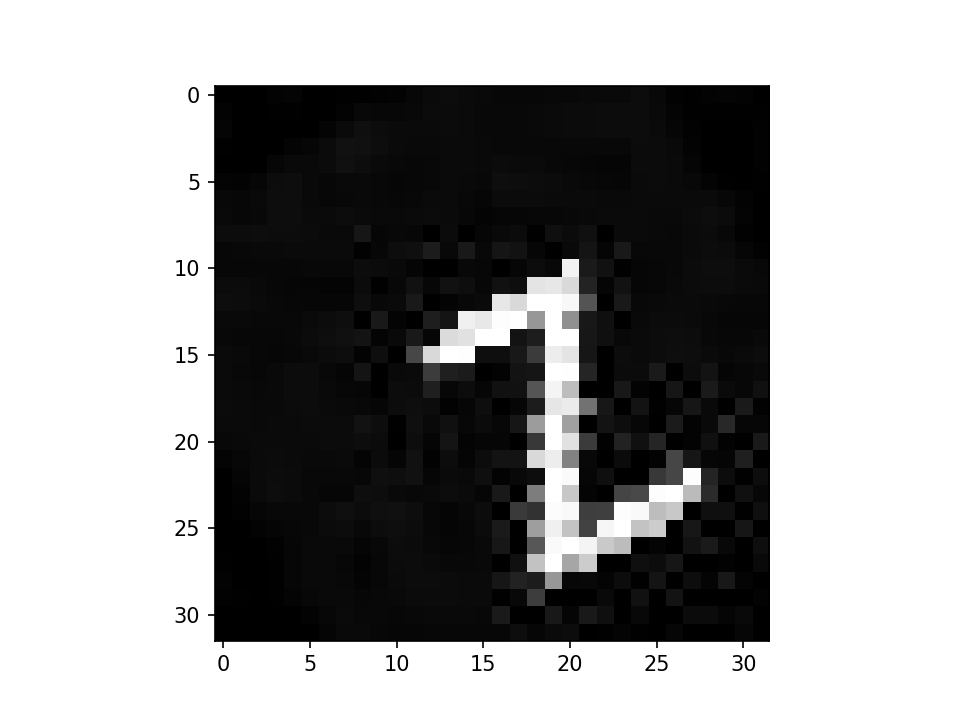

<IPython.core.display.Javascript object>


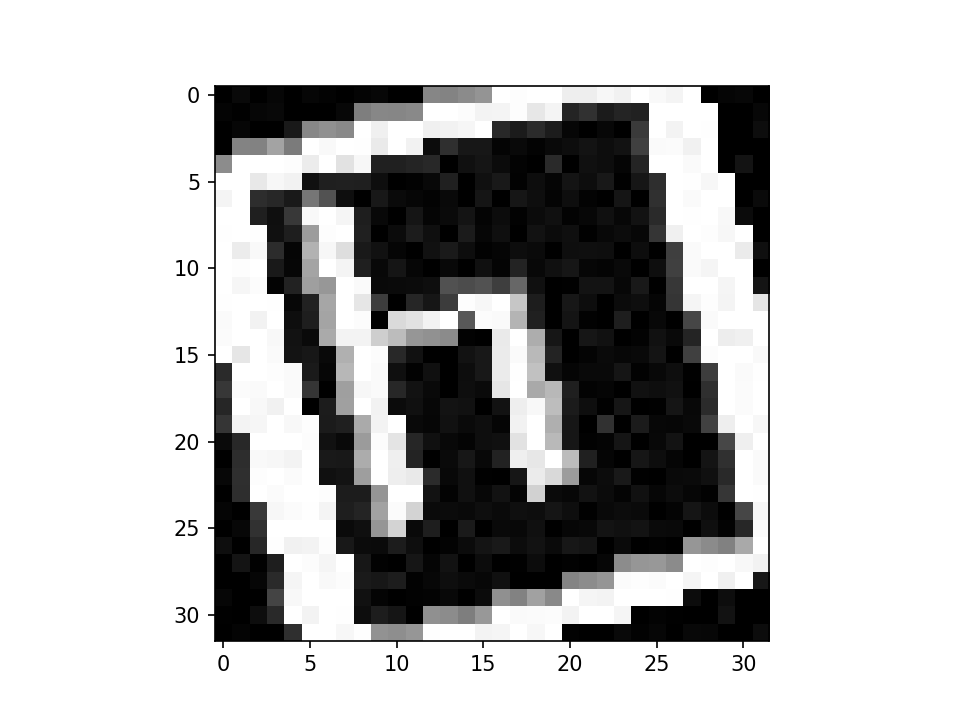

In [10]:
img1 = Image.fromarray(train_features[4].reshape(32,32))
img2 = Image.fromarray(train_features[5].reshape(32,32))

plt.figure()
plt.imshow(img1, cmap='gray')
plt.figure()
plt.imshow(img2, cmap='gray')

In [11]:
print(data.oneHotDecode(train_labels[4]))
print(data.oneHotDecode(train_labels[5]))

z
h


In [12]:
print("- Tamanho do conjunto de treino: %d" % len(train_features))
print("- Tamanho do conjunto de teste: %d" % len(test_features))

- Tamanho do conjunto de treino: 111800
- Tamanho do conjunto de teste: 34400


# Criando rede neural

In [13]:
inputShape = train_features[0].shape[0]
numClasses = data.getClassCount()

print("- Tamanho linear dos dados de entrada: %d" % inputShape)

- Tamanho linear dos dados de entrada: 32


### MLP

In [18]:
model = keras.Sequential()
model.add(keras.layers.Dense(700, input_dim=inputShape, activation='selu'))
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.normalization.BatchNormalization())

model.add(keras.layers.Dense(500, input_dim=inputShape, activation='selu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300, input_dim=inputShape, activation='selu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(numClasses, activation="softmax"))

### CNN

In [14]:
model = keras.Sequential()

model.add(keras.layers.Lambda(lambda image: image * (1/255.0), input_shape = (inputShape,inputShape,1)))

model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='selu'))

model.add(keras.layers.Conv2D(64, (3, 3), activation='selu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='selu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(numClasses, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

## Compilando modelo

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Checkpoint

In [17]:
checkDir = "checkpoint/"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkDir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Treinando modelo

In [21]:
history = model.fit(train_features, train_labels, epochs=10, batch_size=256,
                    validation_data=(test_features, test_labels), callbacks=[model_checkpoint_callback])

Epoch 1/10
437/437 [==============================] - 20s 46ms/step - loss: 0.1693 - accuracy: 0.9427 - val_loss: 0.4248 - val_accuracy: 0.9062
Epoch 2/10
437/437 [==============================] - 20s 46ms/step - loss: 0.1694 - accuracy: 0.9426 - val_loss: 0.3739 - val_accuracy: 0.9131
Epoch 3/10
437/437 [==============================] - 20s 46ms/step - loss: 0.1702 - accuracy: 0.9422 - val_loss: 0.3249 - val_accuracy: 0.9198
Epoch 4/10
437/437 [==============================] - 20s 46ms/step - loss: 0.1648 - accuracy: 0.9447 - val_loss: 0.3664 - val_accuracy: 0.9090
Epoch 5/10
437/437 [==============================] - 20s 46ms/step - loss: 0.1670 - accuracy: 0.9444 - val_loss: 0.3965 - val_accuracy: 0.9135
Epoch 6/10
437/437 [==============================] - 20s 46ms/step - loss: 0.1656 - accuracy: 0.9440 - val_loss: 0.3632 - val_accuracy: 0.9151
Epoch 7/10
437/437 [==============================] - 20s 46ms/step - loss: 0.1567 - accuracy: 0.9469 - val_loss: 0.3711 - val_accuracy:

<IPython.core.display.Javascript object>


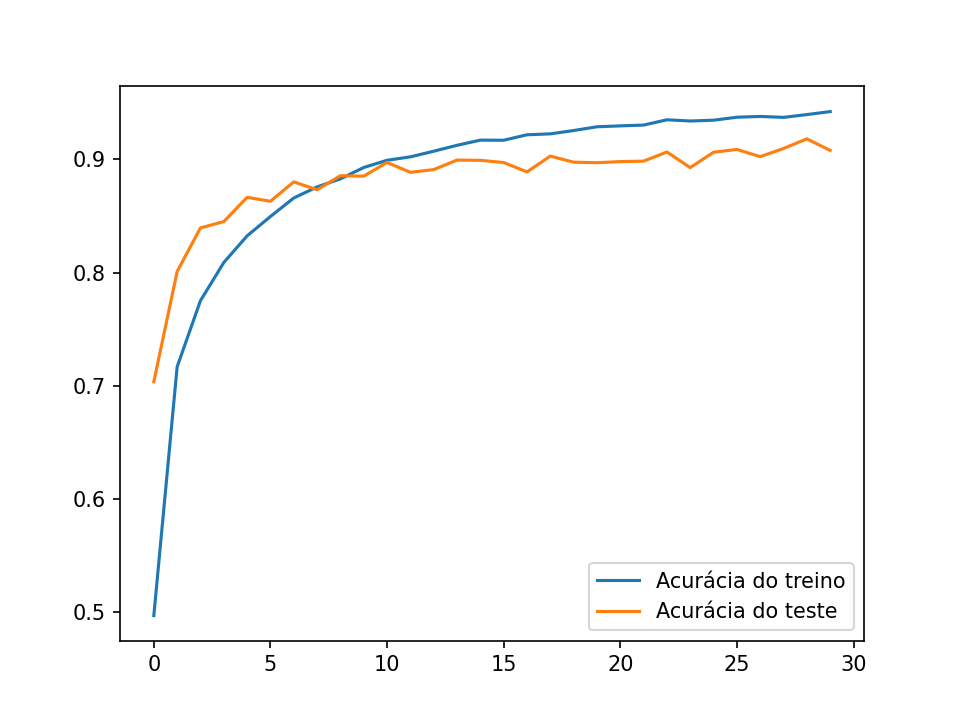

In [19]:
plt.figure()
plt.plot(history.history['accuracy'], label="Acurácia do treino")
plt.plot(history.history['val_accuracy'], label = "Acurácia do teste")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


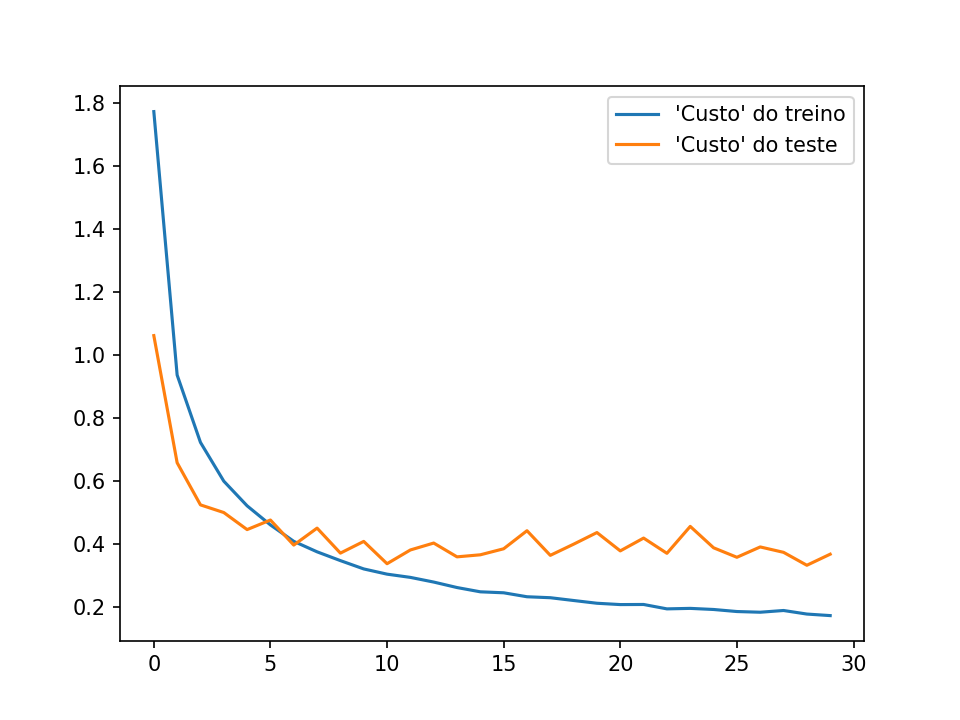

In [20]:
plt.figure()
plt.plot(history.history['loss'], label = "'Custo' do treino")
plt.plot(history.history['val_loss'], label= "'Custo' do teste")
plt.legend()
plt.show()

# Salvando modelo

In [22]:
modelDir = "model/"
model.save(modelDir)

with open(modelDir + "classes.txt",'w') as f:
    for c in data.classes:
        f.write(str(c) + " ")

INFO:tensorflow:Assets written to: model/assets


# Avaliando modelo

__Carrega o melhor peso__

In [18]:
model.load_weights(checkDir)

In [19]:
_, accuracy = model.evaluate(test_features, test_labels)
print("Acurácia do modelo nos dados de teste: %.2f%%" % (accuracy*100.0))

1075/1075 [==============================] - 32s 4ms/step - loss: 0.3273 - accuracy: 0.9197
Acurácia do modelo nos dados de teste: 91.98%


# Testando modelo

__MLP__

In [26]:
import cv2

# Função para carregar imagem
def loadImage(fileName, printImg = False):
    # Carrega a imagem e aplica um threshold para ficar igual
    # as imagens do treino
    img = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU) 

    # Ajusta o tamanho da imagem
    img = cv2.resize(img, (32,32))
    
    if printImg:
        plt.figure()
        plt.imshow(img, cmap='gray')
    
    return list(img.flatten().tolist())


def getChar(x):
    label = model.predict([x], batch_size=1)
    
    char = data.oneHotDecode(label)
    
    return char

__CNN__

In [37]:
import cv2

# Função para carregar imagem
def loadImage(fileName, printImg = False):
    # Carrega a imagem e aplica um threshold para ficar igual
    # as imagens do treino
    img = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    # Ajusta o tamanho da imagem
    img = cv2.resize(img, (32,32))
    
    if printImg:
        plt.figure()
        plt.imshow(img, cmap='gray')
        
    img = img.reshape((1,32,32,1))
    
    return img


def getChar(x):
    label = model.predict(x, batch_size=1)
    
    char = data.oneHotDecode(label)
    
    return char

In [27]:
x = loadImage("testes/letraa.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi a


In [22]:
x = loadImage("testes/letraa3.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi a


In [23]:
x = loadImage("testes/letra.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi A


In [24]:
x = loadImage("testes/letraAu.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi A


In [25]:
x = loadImage("testes/cidilha.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi G


In [26]:
x = loadImage("testes/cidilhau.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi C


<IPython.core.display.Javascript object>


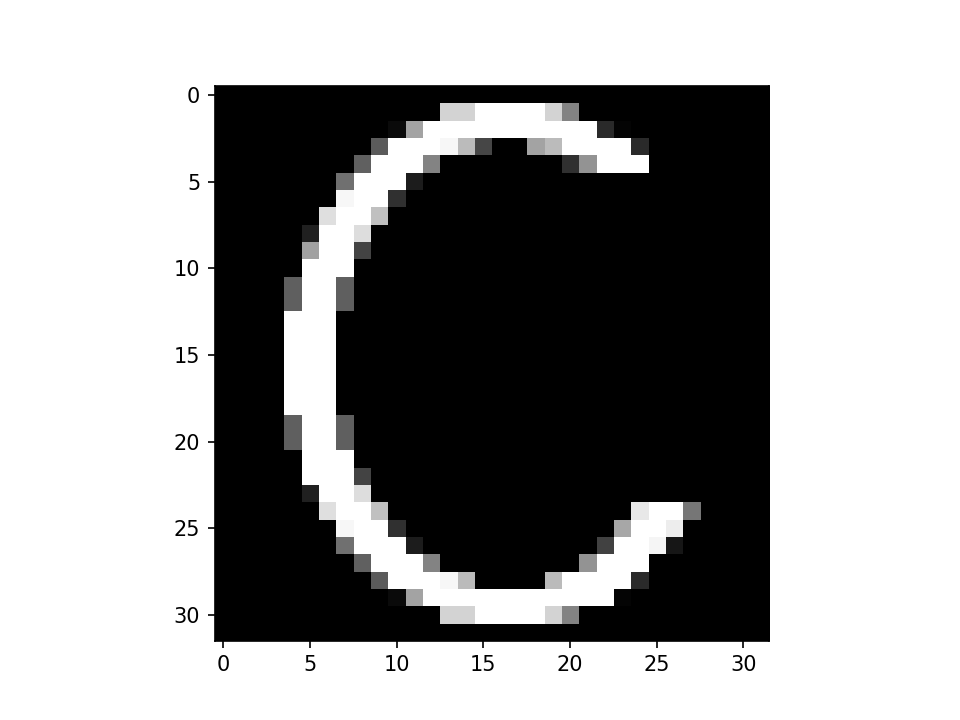

O caractere reconhecido foi C


In [79]:
x = loadImage("testes/letra.png", True)
c = getChar(x)
print("O caractere reconhecido foi %s" % c)